# Прогностическая модель рисков для беременных женщин

## Цель проекта

Разработать модель машинного обучения для прогнозирования уровня риска беременности на основе клинических данных.

---

## 📅 Условия задачи

* **Задача:** построить ML-модель для прогнозирования уровня риска у беременных
* **Срок:** до **1 недели**
* **Метрика:** выбирается самостоятельно (accuracy, F1-score, ROC AUC и др.)
* **Формат сдачи:** ссылка на **Google Colab** с:

  * выполненным кодом
  * финальными **метриками**
  * **матрицей ошибок** на **тестовой выборке**
* **Особенности:** в **последних ячейках ноутбука** необходимо вывести метрики и **матрицу ошибок** как на трейне, так и на тесте.

---

## 📁 Описание данных

Каждая строка соответствует одному случаю беременности с измеренными медицинскими признаками.

| Название признака | Описание                                                         |
| ----------------- | ---------------------------------------------------------------- |
| `Age`             | Возраст женщины в годах на момент беременности                   |
| `SystolicBP`      | Систолическое (верхнее) артериальное давление в мм рт. ст.       |
| `DiastolicBP`     | Диастолическое (нижнее) артериальное давление в мм рт. ст.       |
| `BS`              | Уровень глюкозы в крови (ммоль/л)                                |
| `BodyTemp`        | Температура тела (градусы Фаренгейта)                                |
| `HeartRate`       | Частота сердечных сокращений в состоянии покоя (уд./мин)         |
| `RiskLevel`       | Целевой признак — уровень риска при беременности (классификация) |




<a id='content'></a>

<h1>Содержание</h1>
    <ul>
        <li><a href="#data-loading">Импорт библиотек и загрузка данных</a></li>
        <li><a href="#eda-preprocessing">Первичный анализ данных (EDA) и предобработка данных</a></li>
        <li><a href="#data-merging">Feature Engineering (создание новых признаков)</a></li>
        <li><a href="#merged-eda-preprocessing">Исследовательский анализ</a></li>
        <li><a href="#data-preparation">Разделение данных на обучающую и тестовую выборки</a></li>
        <li><a href="#model-training">Обучение моделей</a></li>
        <li><a href="#model-selection">Выбор лучшей модели/ Оценка модели на тестовой выборке</a></li>
        <li><a href="#conclusion-recommendations">Общий вывод и оценка важности признаков</a></li>
    </ul>

<a href='#content'>Вернуться к оглавлению</a> 

## <h2 id="data-loading">Импорт библиотек и загрузка данных</h2>

In [51]:
#!pip install pandas==2.2.2 seaborn==0.13.2 numba==0.60.0 -q

In [52]:
#!pip install numpy==2.26.4 matplotlib==3.9.0 -q

In [53]:
#!pip install --upgrade scikit-learn==1.2.2 jinja2==3.1.2 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.6 which is incompatible.
dataprep 0.4.1 requires jinja2<3.0,>=2.11, but you have jinja2 3.1.6 which is incompatible.
dataprep 0.4.1 requires pandas<2.0,>=1.1, but you have pandas 2.2.2 which is incompatible.


In [4]:
# Стандартные библиотеки
import math
import re
import warnings
from collections import Counter

# Основные библиотеки анализа данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Статистические и научные библиотеки
from scipy.cluster import hierarchy
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Библиотеки машинного обучения
import sklearn
import shap
from catboost import CatBoostClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_predict,
    StratifiedKFold,
)

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
)

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    precision_recall_curve,
    classification_report,
    f1_score,
)


In [5]:
warnings.filterwarnings("ignore") 

In [6]:
pantone_colors = {    
    "Greenery": "#88B04B",        
    "Ultra Violet": "#5F4B8B",    
    "Living Coral": "#FF6F61",    
    "Classic Blue": "#4F7DA1",    
    "Serenity": "#92A8D1",        
    "Very Peri": "#6667AB",        
    "Viva Magenta": "#BB2649",    
    "Peach Fuzz": "#F7D2C5",      
    "Lush Green": "#1E5B4F"       
}

In [7]:
# Функция для построения гистограмм
def plot_histograms(df, 
                    columns, 
                    rows=2, 
                    color=pantone_colors['Classic Blue']):
    """
    Строит гистограммы для указанных числовых столбцов в DataFrame.

    Args:
        df: DataFrame с данными.
        columns: Список названий числовых столбцов.
        rows: Количество рядов в сетке графиков.
    """
    num_plots = len(columns)
    cols = num_plots // rows + (num_plots % rows > 0)  
    fig, axes = plt.subplots(nrows=rows, 
                             ncols=cols, 
                             figsize=(cols*5, rows*4))
    axes = axes.flatten()  

    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, ax=axes[i],
                     kde=True, 
                    color=color, 
                    stat='probability')
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()


#Функция для загрузки дата сета, 
#file_name - строка с названием файла для загрузки, 
#df_name - название для загружаемого датасета
#sep - разделитель, по умолчанию ','
#graf - строим ли графики

def loading_data(file_name, df_name, sep=',', graf=True, missingno=False, 
                 num_columns=3, figsize=(15,10), bins=30, 
                 color=pantone_colors['Classic Blue']):
    
    try:
        df = pd.read_csv('assets/'+  file_name, sep=sep) 
    except:
        df = pd.read_csv('/datasets/' + file_name, sep=sep) 
    
    pd.set_option("display.max_columns", None)
    
    print(df_name)
    display(df.head(5))
    print('-'*80)
    print('Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти ')
    print()
    print(df.info())
    print('-'*80)
    print('Оценим количество пропущенных значений в каждом столбце, в %')
    print()
    display(pd.DataFrame(df.isna().mean()*100)
            .style.format("{:.2f}").background_gradient('coolwarm'))
    #display(df.isna().sum())
    
    if missingno == True:
        print('-'*80)
        print('Визуализируем пропуски в данных')
        msno.matrix(df, figsize = (10,8))
    if graf == True:
        plt.show()
        print('-'*80)
        print('Визуализируем общие данные')
        if 'key' in df.columns:
            df_new = df.drop(columns=['key'])
        else:
            df_new = df

        # Вызываем функцию, указав желаемое количество рядов
        numeric_cols = df_new.select_dtypes(include=['number']).columns
        rows = math.ceil(len(numeric_cols)/num_columns)
        plot_histograms(df_new, numeric_cols, rows=rows, color=color)  # Например, 3 ряда
        
        #g.fig.set_size_inches(figsize)
        
        plt.show()
        #label = 'Гистограмма распределения '+ my_title
        #plt.title(label=label, fontsize = 24, y = 1, color = 'midnightblue')  
        #sns.set_context(rc={'legend.fontsize': 24})
          

    return df

df


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце, в %



,0
Age,0.00
SystolicBP,0.00
DiastolicBP,0.00
BS,0.00
BodyTemp,0.00
HeartRate,0.00
RiskLevel,0.00


--------------------------------------------------------------------------------
Визуализируем общие данные


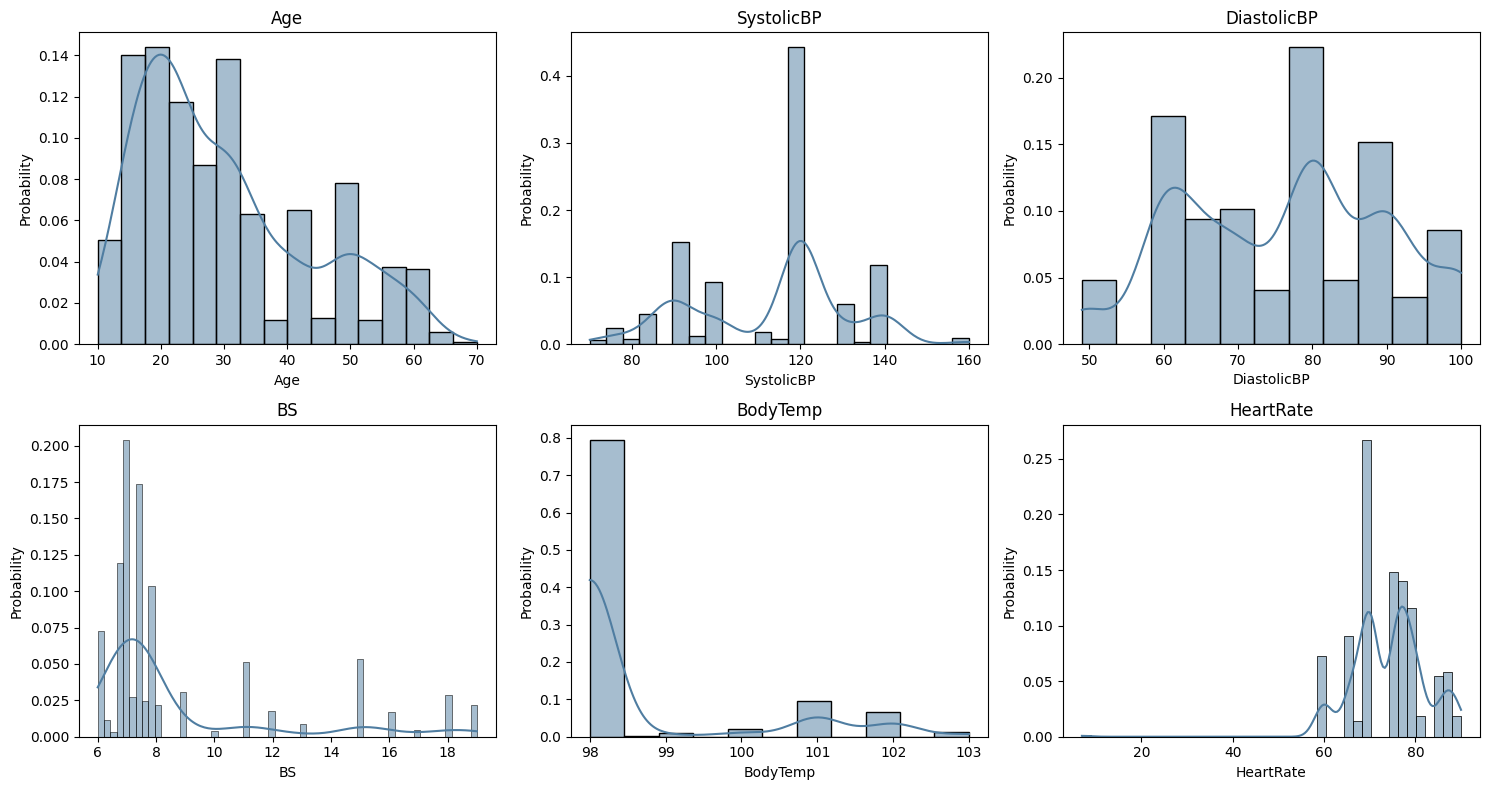

In [8]:
df = loading_data('condition_of_pregnant_woman.csv', 'df')

- Пропуски отсутсвуют
- Тип данных соответсвует содержимому
- Название столбцов в CamelCase, заменим на snake_case

In [9]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


- Возрастные значения: Согласно открытым источникам, случаи беременности и родов зафиксированы в возрасте от 10 до 70 лет. Учитывая это, можно считать, что значения признака age находятся в допустимом диапазоне и не содержат выбросов.

- Пульс: Минимальное значение признака heart_rate составляет 7 ударов в минуту, что вызывает обоснованные сомнения в корректности данных. Такое значение значительно ниже физиологической нормы и, вероятно, является ошибкой ввода. Остальные признаки лежат в пределах допустимых и ожидаемых значений.

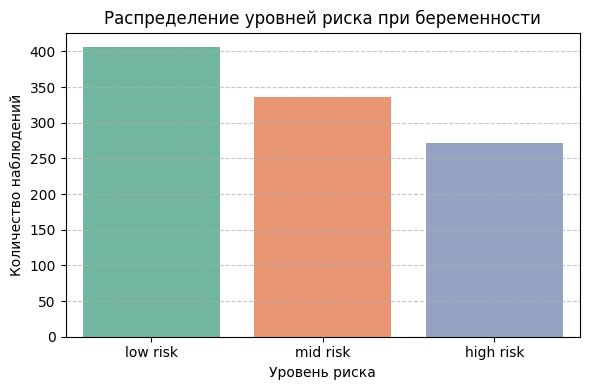

In [10]:
# Подготовка данных
risk_counts = df['RiskLevel'].value_counts().reset_index()
risk_counts.columns = ['RiskLevel', 'count']

# Построение графика
plt.figure(figsize=(6, 4))
sns.barplot(data=risk_counts, x='RiskLevel', y='count', palette='Set2')

plt.title('Распределение уровней риска при беременности')
plt.xlabel('Уровень риска')
plt.ylabel('Количество наблюдений')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Уровень риска (risk_level) представлен тремя классами, отражающими степень угрозы при беременности. Таким образом, перед нами стоит задача мультиклассовой классификации.

<a href='#content'>Вернуться к оглавлению</a> 

## <h2 id="eda-preprocessing">Первичный анализ данных (EDA) и предобработка данных</h2>

In [11]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])$', r'\1_\2', name)  
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)   
    return name.lower()

df.columns = [camel_to_snake(col) for col in df.columns]
df.columns

Index(['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate',
       'risk_level'],
      dtype='object')

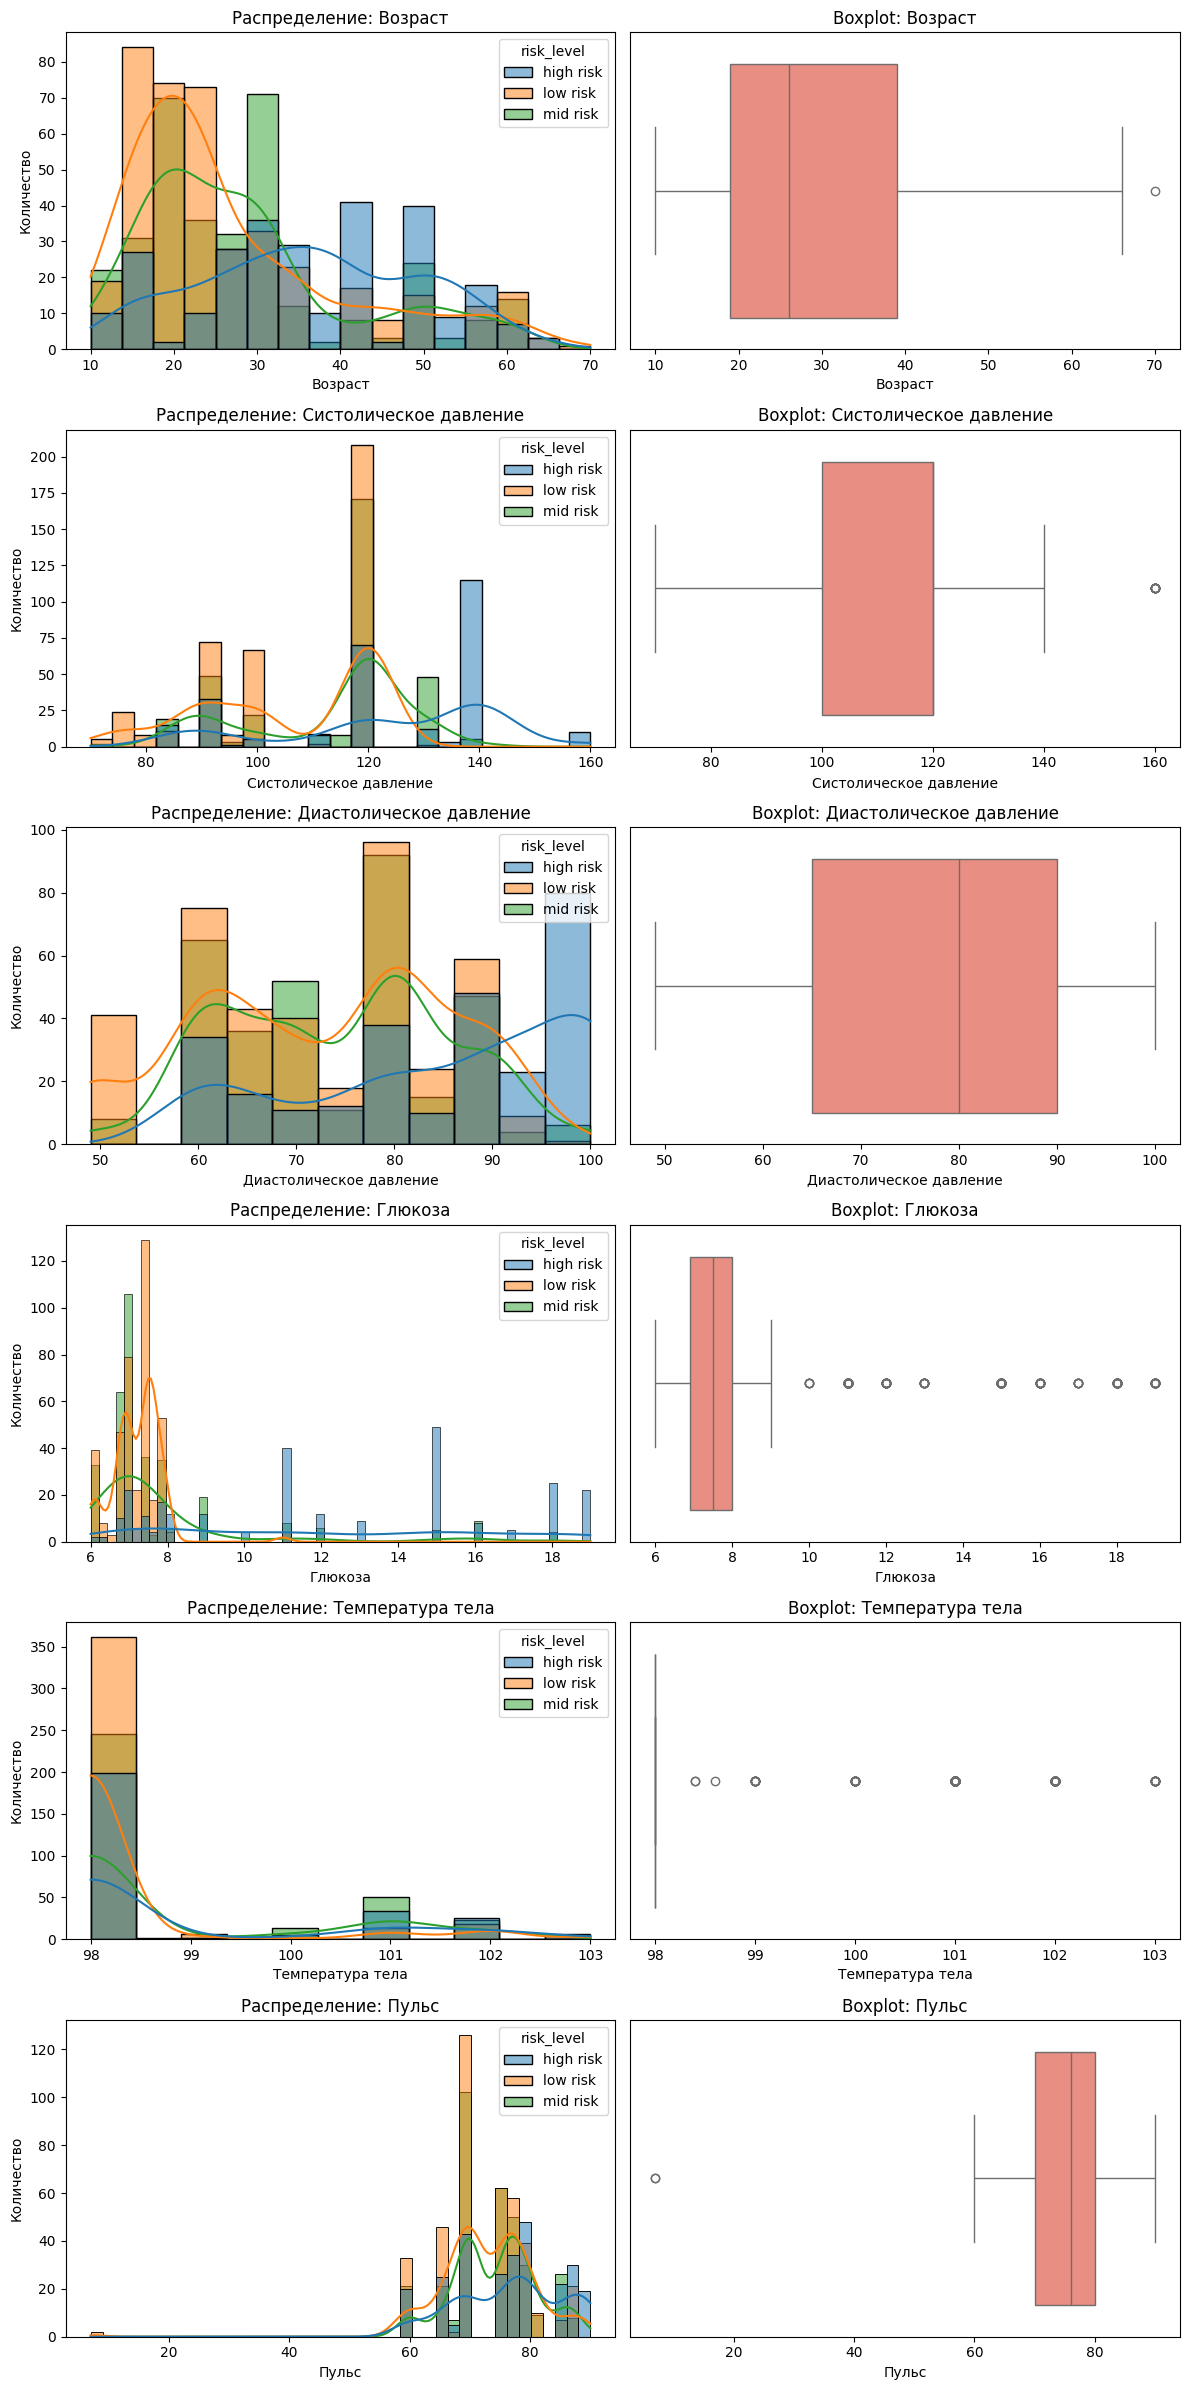

In [12]:
features = ['age', 
            'systolic_bp', 
            'diastolic_bp', 
            'bs', 'body_temp', 
            'heart_rate']
titles = ['Возраст', 
          'Систолическое давление', 
          'Диастолическое давление', 
          'Глюкоза', 
          'Температура тела', 
          'Пульс']

fig, axes = plt.subplots(len(features), 2, figsize=(12, 4 * len(features)))

for i, (feature, title) in enumerate(zip(features, titles)):
    # Гистограмма с hue
    sns.histplot(data=df,
                 x=feature,
                 hue='risk_level',
                 kde=True, 
                 ax=axes[i, 0])
    axes[i, 0].set_title(f'Распределение: {title}')
    axes[i, 0].set_xlabel(title)
    axes[i, 0].set_ylabel('Количество')

    # Boxplot без hue
    sns.boxplot(x=df[feature], ax=axes[i, 1], color='salmon')
    axes[i, 1].set_title(f'Boxplot: {title}')
    axes[i, 1].set_xlabel(title)
    axes[i, 1].set_yticks([])

plt.tight_layout()
plt.show()


- Риск осложнений при беременности возрастает с увеличением возраста будущей матери.

- Повышение артериального давления выше 130 мм рт. ст. сопровождается увеличением уровня риска.

- Увеличение уровня глюкозы в крови и температуры тела также способствует повышению риска.

- Частота сердечных сокращений (пульс) оказывает менее выраженное влияние на уровень риска.

Значения, выходящие за пределы "усов" на диаграммах boxplot, хоть и считаются статистическими выбросами, могут встречаться в реальной клинической практике. Поэтому мы не будем удалять такие наблюдения, если они физиологически обоснованы.

Однако, в данных обнаружено аномально низкое значение пульса — 7 ударов в минуту, что существенно отклоняется от допустимых физиологических норм. Скорее всего, это ошибка ввода (например, опечатка: 7 вместо 70). Такое значение может исказить результаты обучения модели, поэтому оно будет удалено из набора данных.

In [13]:
print('Размер датасета до удаления выброса:', df.shape)
df = df.loc[df['heart_rate'] > 7]
print('Размер датасета после удаления выброса:', df.shape)

Размер датасета до удаления выброса: (1014, 7)
Размер датасета после удаления выброса: (1012, 7)


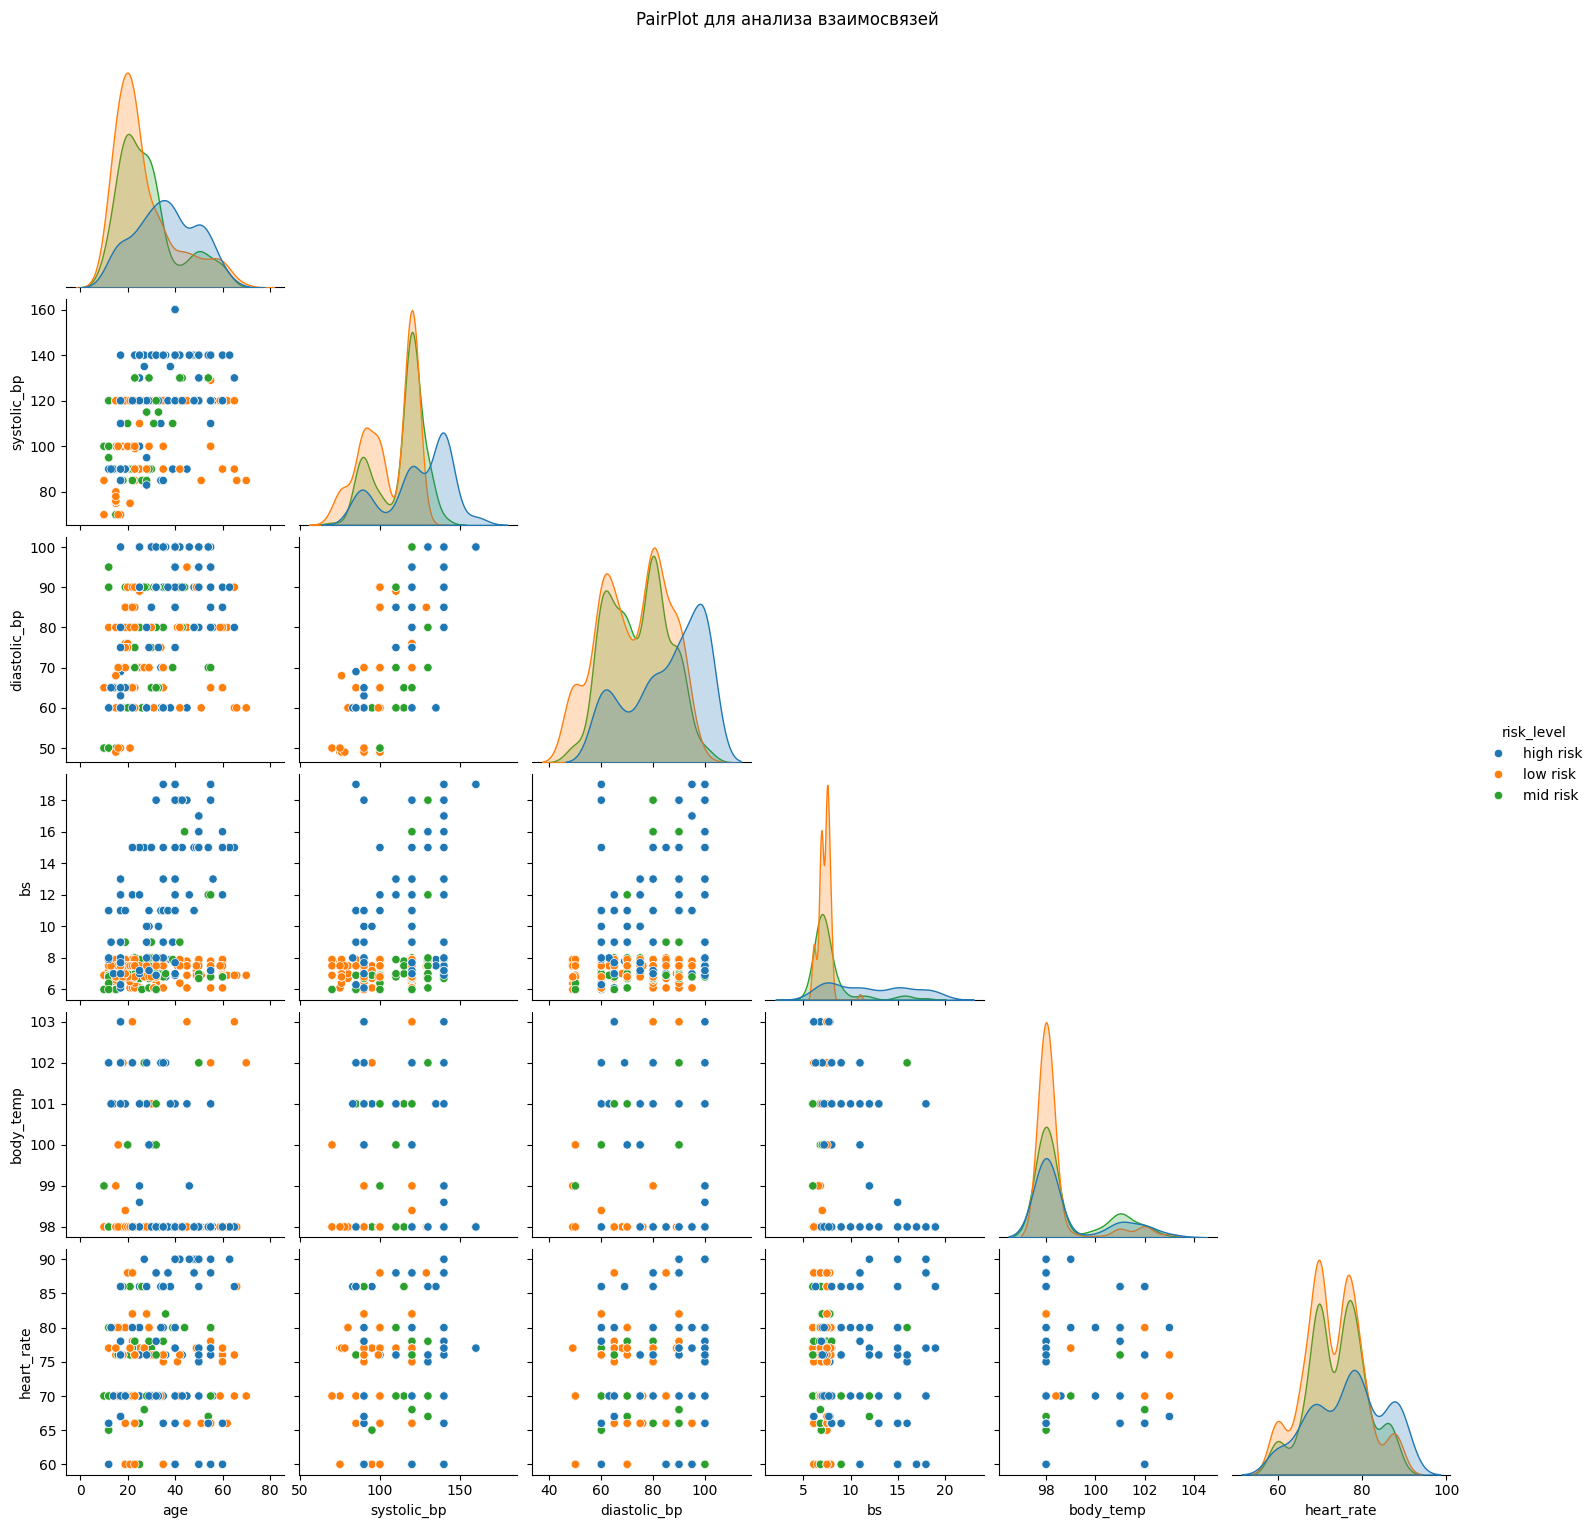

In [14]:
sns.pairplot(df, hue='risk_level', diag_kind='kde', corner=True)
plt.suptitle('PairPlot для анализа взаимосвязей', y=1.02)
plt.show()

Между диастолическим и систолическим артериальным давлением прослеживается ожидаемая квазилинейная корреляция. Это указывает на естественную взаимосвязь между этими двумя показателями, где изменение одного, как правило, сопровождается соразмерным изменением другого.

Наблюдается выраженная зависимость между уровнем глюкозы и фактором риска. В частности, все случаи с низким риском сосредоточены в области низких значений уровня глюкозы, что подчеркивает критическую роль этого показателя в оценке потенциальных угроз.

<a href='#content'>Вернуться к оглавлению</a> 

## <h2 id="data-merging">Feature Engineering (создание новых признаков)</h2>
    

#### Добавим признаки на основаннии медицинских расчетов и отношений:
**Пульсовое давление (pulse_pressure)**:

*Расчет: pulse_pressure = systolic_bp - diastolic_bp*

Значение: Высокое пульсовое давление может указывать на жесткость артерий и быть маркером сердечно-сосудистых заболеваний. Это важный независимый предиктор.

---


In [15]:
df['pulse_pressure'] = df['systolic_bp'] - df['diastolic_bp']

In [16]:
df.head()

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level,pulse_pressure
0,25,130,80,15.0,98.0,86,high risk,50
1,35,140,90,13.0,98.0,70,high risk,50
2,29,90,70,8.0,100.0,80,high risk,20
3,30,140,85,7.0,98.0,70,high risk,55
4,35,120,60,6.1,98.0,76,low risk,60


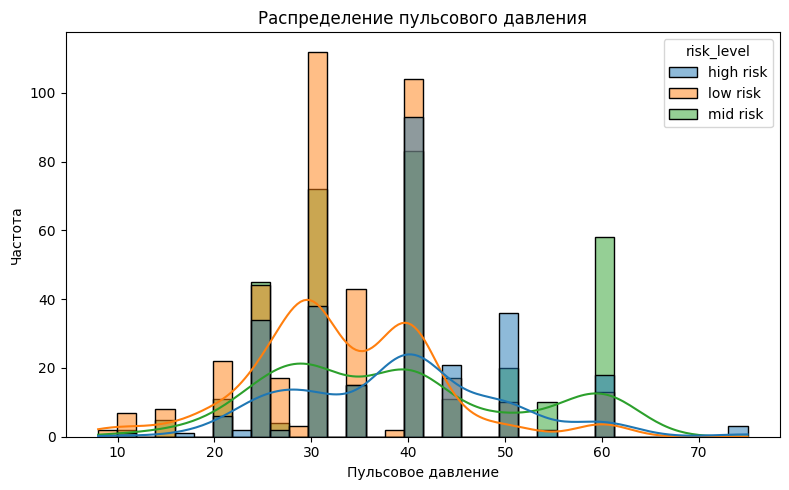

In [17]:
fig, ax= plt.subplots(figsize=(8, 5)) 

sns.histplot(df, 
             x=df['pulse_pressure'], 
             hue='risk_level', 
              
             kde=True)
ax.set_title('Распределение пульсового давления')
ax.set_xlabel('Пульсовое давление')
ax.set_ylabel('Частота')
plt.tight_layout() 
plt.show()

#### Добавим категориальный признак, основанные на пороговых значениях:

**Возрастные группы (age_bins):**

*Расчет: Разбить age на категории.*

Значение: Может захватить нелинейные зависимости, где влияние возраста на риск меняется в разные периоды жизни.
Возрастные категории:

**Подростковая беременность:**

< 15 лет: Самая юная группа.
Риски: Высокий риск осложнений для матери и ребенка (преждевременные роды, низкий вес при рождении, преэклампсия), социальные и психологические проблемы, отсутствие социальной поддержки, недостаточное питание, незрелость репродуктивной системы.

15-19 лет: Подростки.
Риски: Риски все еще повышены по сравнению с оптимальным возрастом, но ниже, чем у младших подростков. Психологическая и социальная незрелость, завершение образования, экономические трудности.

**Оптимальный детородный возраст:**

20-24 года: Ранний взрослый возраст.
Риски: Считается одним из наиболее безопасных периодов для беременности с точки зрения физиологических рисков.

25-29 лет: Середина оптимального возраста.
Риски: Продолжает быть оптимальным периодом. Риски минимальны, если нет сопутствующих заболеваний.

30-34 года: Поздний оптимальный возраст.
Риски: Риски начинают незначительно расти, но в целом все еще низки. Небольшое увеличение риска гестационного диабета и гипертонии.

**Возраст повышенного риска:**

35-39 лет:

Риски: Значительное увеличение риска гестационного диабета, гипертонии, преэклампсии, предлежания плаценты, преждевременных родов, хромосомных аномалий у плода (синдром Дауна), мертворождения, кесарева сечения.

40-44 года:
Риски: Риски еще более выражены, чем в 35-39 лет. Увеличивается вероятность использования вспомогательных репродуктивных технологий (ВРТ), что само по себе может нести дополнительные риски.

45-49 лет:
Риски: Очень высокие риски для матери (сердечно-сосудистые заболевания, инсульты, тромбоэмболии) и плода (хромосомные аномалии, преждевременные роды, низкий вес при рождении). Часто это беременности после ЭКО.
50 лет и старше (50-70 лет):
Риски: Чрезвычайно высокие риски. Большинство таких беременностей достигается с помощью ВРТ (донорские яйцеклетки), что подразумевает дополнительные медицинские вмешательства и связанные с ними риски. Риски для матери включают инфаркт миокарда, инсульт, почечную недостаточность, а для ребенка - преждевременные роды, задержку внутриутробного развития и мертворождение.

In [18]:
bins = [10, 15, 19, 24, 29, 34, 39, 44, 49, 71] 
labels = [
    '<15',
    '15-19',
    '20-24',
    '25-29',
    '30-34',
    '35-39',
    '40-44',
    '45-49',
    '50+' 
]
df['age_bins'] = pd.cut(df['age'], 
                        bins=bins, 
                        labels=labels, 
                        right=True, 
                        include_lowest=True)

print("\nРаспределение по новым возрастным категориям:")
df['age_bins'].value_counts().sort_index()


Распределение по новым возрастным категориям:


age_bins
<15      114
15-19    163
20-24    179
25-29    128
30-34    110
35-39     66
40-44     69
45-49     45
50+      138
Name: count, dtype: int64

In [19]:
df.head()

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level,pulse_pressure,age_bins
0,25,130,80,15.0,98.0,86,high risk,50,25-29
1,35,140,90,13.0,98.0,70,high risk,50,35-39
2,29,90,70,8.0,100.0,80,high risk,20,25-29
3,30,140,85,7.0,98.0,70,high risk,55,30-34
4,35,120,60,6.1,98.0,76,low risk,60,35-39


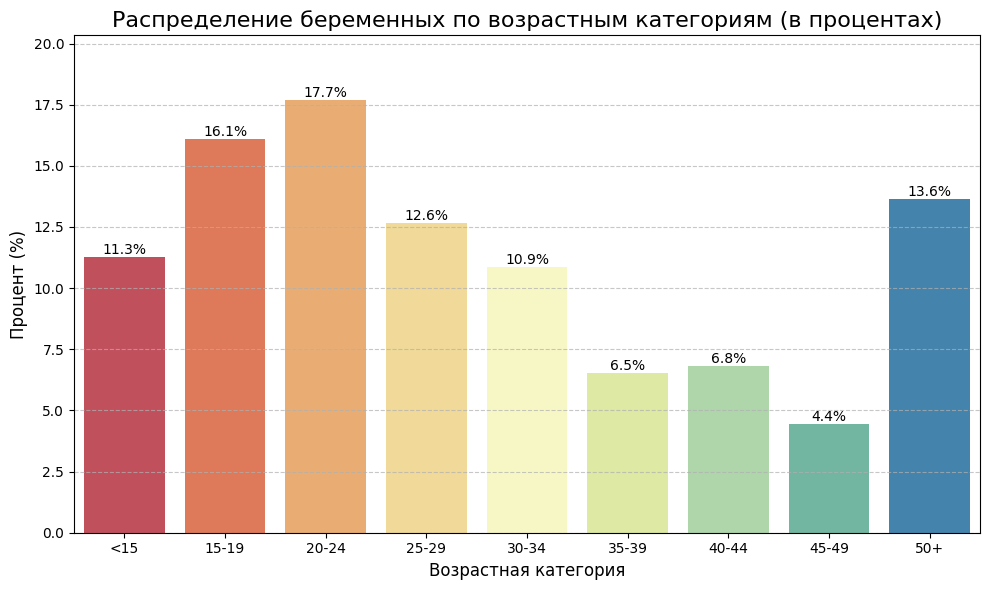

In [20]:
percentage_counts = (df['age_bins']
                     .value_counts(normalize=True)
                     .mul(100)
                     .reset_index())
percentage_counts.columns = ['Возрастная категория', 'Процент']

plt.figure(figsize=(10, 6)) 
ax = sns.barplot(x='Возрастная категория', 
                 y='Процент', 
                 data=percentage_counts, 
                 palette='Spectral')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., 
            height,                     
            f'{height:.1f}%',               
            ha='center', va='bottom',       
            fontsize=10, color='black')


plt.title('Распределение беременных по возрастным категориям (в процентах)', 
          fontsize=16)
plt.xlabel('Возрастная категория', fontsize=12)
plt.ylabel('Процент (%)', fontsize=12)
plt.ylim(0, percentage_counts['Процент'].max() * 1.15) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


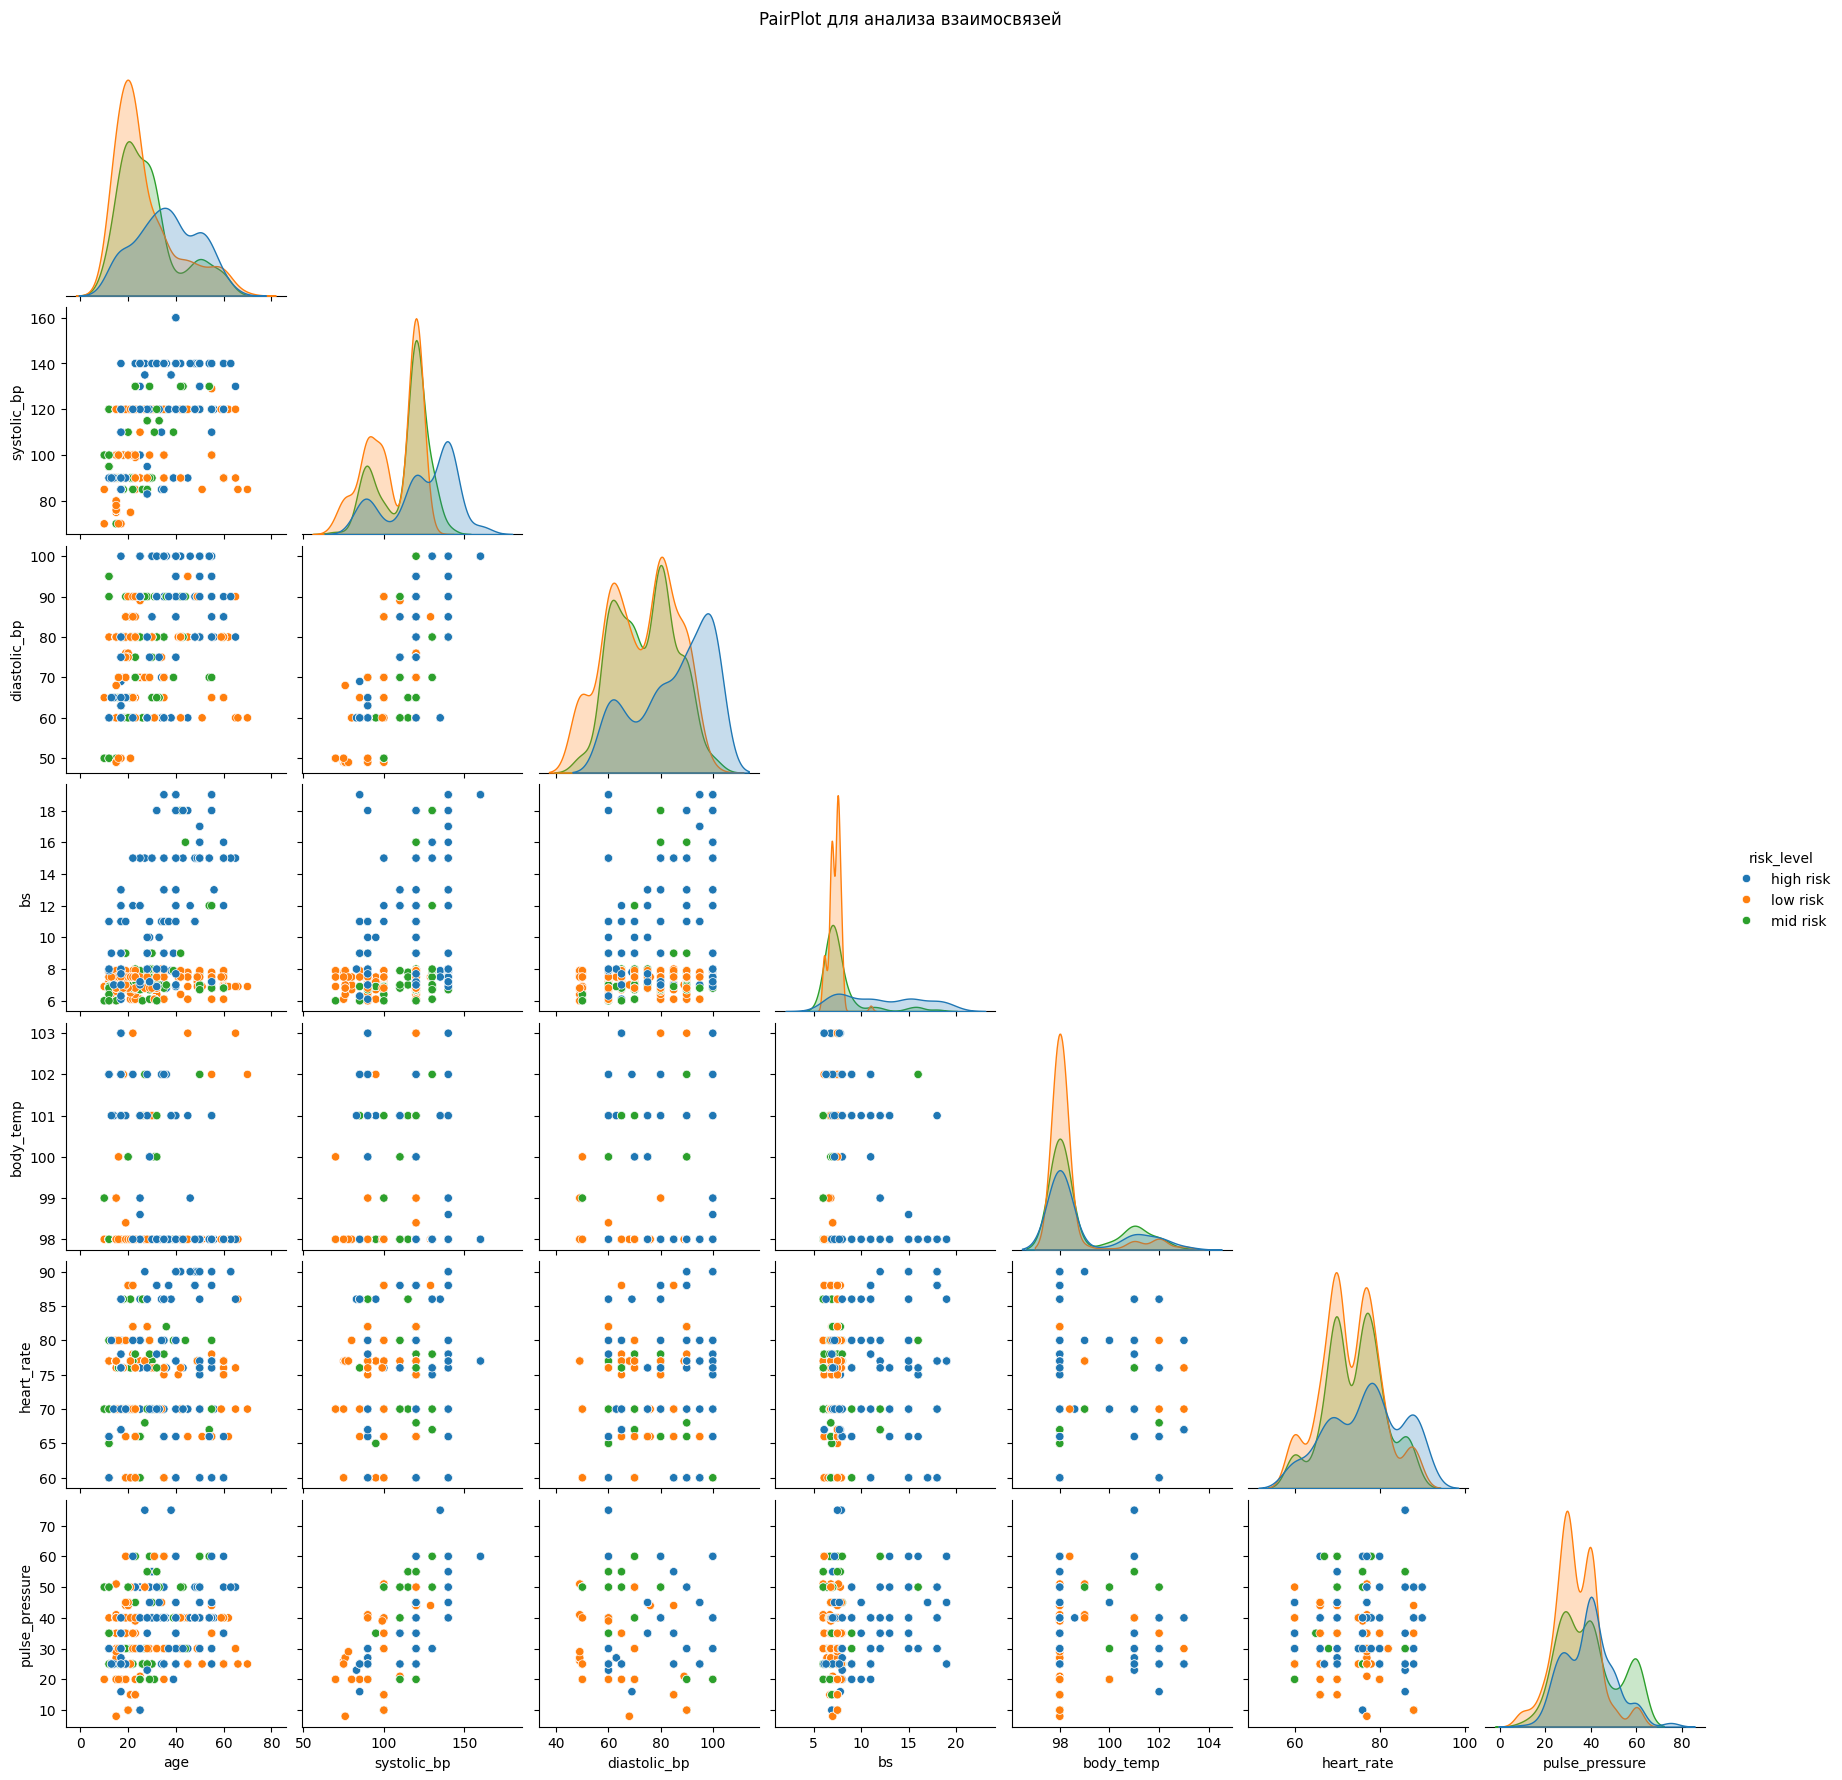

In [21]:
sns.pairplot(df[['age', 
                 'systolic_bp', 
                 'diastolic_bp', 
                 'bs', 'body_temp', 
                 'heart_rate',
                 'risk_level', 
                 'pulse_pressure', 
                 'age_bins']], hue='risk_level', diag_kind='kde', corner=True)
plt.suptitle('PairPlot для анализа взаимосвязей', y=1.02)
plt.show()

Признак pulse_pressure демонстрирует хорошую дифференциацию по целевому признаку. На графике зависимости от систолического давления отчётливо видны различия между классами риска. Кроме того, на гистограмме pulse_pressure заметно выделяется область, соответствующая средней степени риска, что подтверждает его информативность для классификации.

<a href='#content'>Вернуться к оглавлению</a> 

## <h2 id="merged-eda-preprocessing">Исследовательский анализ</h2>


In [22]:
interval_cols = [
    'age',
    'systolic_bp',
    'diastolic_bp',
    'bs',
    'body_temp',
    'heart_rate',
    'pulse_pressure',
]

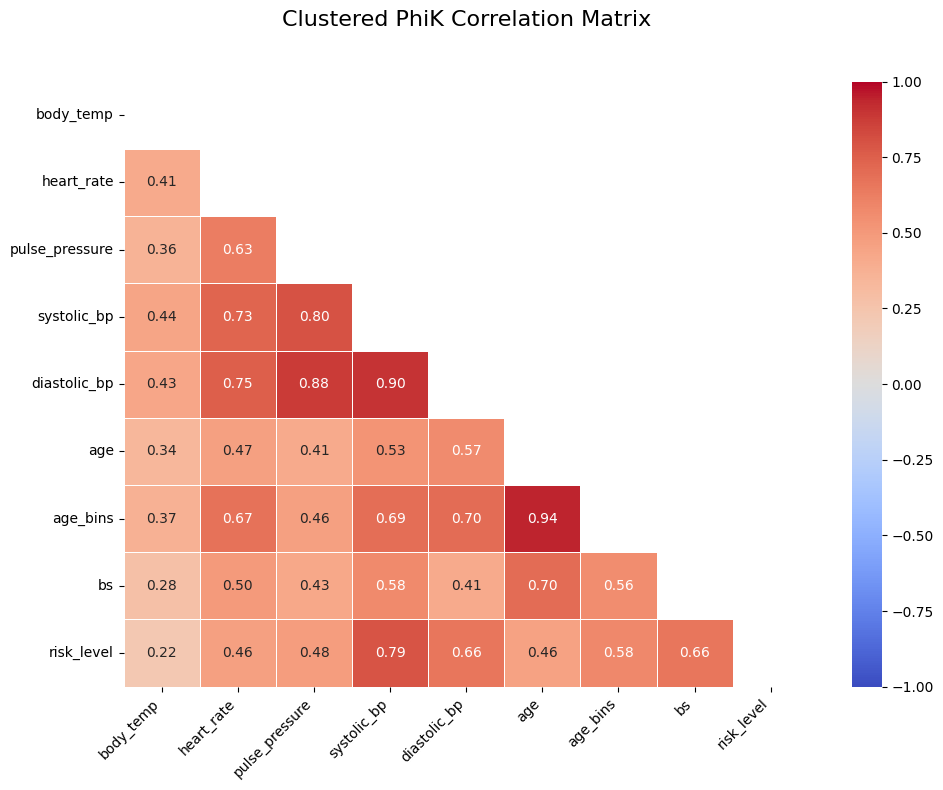

In [23]:
# Вычисление матрицы корреляций
phik_overview = phik_matrix(df, interval_cols=interval_cols)

# Кластеризация признаков
corr_linkage = hierarchy.ward(phik_overview)
cluster_order = hierarchy.leaves_list(corr_linkage)
clustered_matrix = phik_overview.iloc[cluster_order, cluster_order]

# Визуализация с группировкой
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(clustered_matrix, dtype=bool))

sns.heatmap(
    clustered_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor='white',
    #cbar_kws={'shrink': 0.8},
    annot_kws={'size': 10}
)

plt.title('Clustered PhiK Correlation Matrix', fontsize=16, pad=40)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Между диастолическим и систолическим давлением наблюдается высокая корреляция. Показатель pulse_pressure (разница между систолическим и диастолическим давлением) уже отражает взаимосвязь между этими двумя признаками. Поэтому, чтобы избежать мультиколлинеарности и избыточности, целесообразно исключить diastolic_bp, сохранив при этом информативность признаков.

Признаки age и age_bins также мультиколлинеарны, что ожидаемо, так как age_bins является категоризованной формой возраста. Однако, age_bins демонстрирует более выраженную связь с целевой переменной, поэтому для модели предпочтительно оставить именно его.

### Сделаем проверку на мультиколлинеарность с помощью VIF — фактора инфляции дисперсии

In [24]:
try:
    df = df.drop(columns=['age', 'diastolic_bp'])
except KeyError as e:
    missing = [col for col in ['age', 
                               'diastolic_bp'] if col not in df.columns]
    print(f"Предупреждение: Столбцы уже удалены или отсутствуют: {missing}")

df.columns

Index(['systolic_bp', 'bs', 'body_temp', 'heart_rate', 'risk_level',
       'pulse_pressure', 'age_bins'],
      dtype='object')

In [25]:
interval_cols = ['systolic_bp', 
                 'bs', 
                 'body_temp', 
                 'heart_rate', 
                 'pulse_pressure']

X = df[interval_cols].copy()  

# Добавляем константу (обязательная часть для расчета VIF)
X = sm.add_constant(X)

# Расчёт VIF
vif_data = pd.DataFrame()
vif_data["Признак"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(X.shape[1])]

# Убираем константу из вывода
vif_data = vif_data[vif_data["Признак"] != "const"]
vif_data.sort_values(by='VIF')


,Признак,VIF
4,heart_rate,1.048359
3,body_temp,1.102426
2,bs,1.297878
5,pulse_pressure,1.826495
1,systolic_bp,2.300061


Коэфициент VIF ниже 5 - допустимый уровень мультиколлинеарности.

<a href='#content'>Вернуться к оглавлению</a> 

## <h2 id="data-preparation">Разделение данных на обучающую и тестовую выборки</h2>

In [26]:
X = df.drop(columns = 'risk_level')
y = df['risk_level']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [28]:
print('Размеры обучающих выборок:')
print(X_train.shape)
y_train.shape

Размеры обучающих выборок:
(809, 6)


(809,)

In [29]:
print('Размеры тестовых выборок:')
print(X_test.shape)
y_test.shape

Размеры тестовых выборок:
(203, 6)


(203,)

In [30]:
counts = y.value_counts(normalize=True).mul(100)
counts

risk_level
low risk     39.920949
mid risk     33.201581
high risk    26.877470
Name: proportion, dtype: float64

In [31]:
def check_stratify(counts_list, titles):
    risk_labels = ['низкий', 'средний', 'высокий']
    
    plt.figure(figsize=(15, 5))  

    for i, (counts, title) in enumerate(zip(counts_list, titles), 1):
        ax = plt.subplot(1, 3, i)
        sns.barplot(x=list(range(len(counts))), 
                    y=counts,  
                    ax=ax)

        for p in ax.patches:
            ax.annotate(
                f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=10
            )

        ax.set_xticklabels(risk_labels)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Уровень риска', fontsize=12)
        ax.set_ylabel('Процент (%)', fontsize=12)

    plt.tight_layout()
    plt.show()

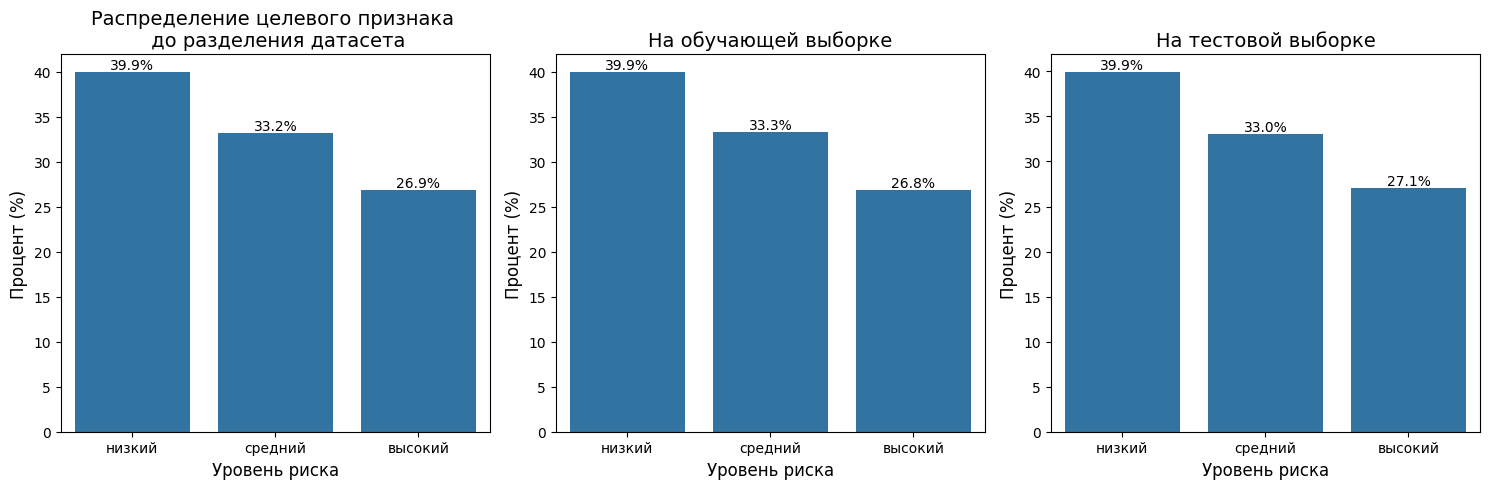

In [32]:
check_stratify([y.value_counts(normalize=True).mul(100),
                y_train.value_counts(normalize=True).mul(100),
                y_test.value_counts(normalize=True).mul(100)], 
                ['Распределение целевого признака \n до разделения датасета', 
                 'На обучающей выборке', 
                 'На тестовой выборке'] )

Баланс классов сохранен.

<a href='#content'>Вернуться к оглавлению</a> 

## <h2 id="model-training">Обучение моделей машинного обучения</h2>


Исходный датасет содержит 1000 строк, 6 признаков и 3 класса, которые необходимо предсказать.

Так как важным требованием является интерпретируемость модели, для дальнейшего анализа будут рассмотрены следующие алгоритмы:

**Логистическая регрессия** (LogisticRegression(multi_class='multinomial', solver='lbfgs'))
Несмотря на отсутствие явных линейных зависимостей (что показал визуальный анализ), данная модель может служить базовой отправной точкой для сравнения качества других методов.

**Случайный лес** (RandomForestClassifier)
Обеспечивает более высокую гибкость по сравнению с логистической регрессией и позволяет оценивать важность признаков, что повышает интерпретируемость.

**CatBoost** (catboost.CatBoostClassifier)
Современный градиентный бустинг, демонстрирующий хорошее качество на табличных данных. Также поддерживает интерпретируемость через встроенные инструменты визуализации важности признаков и совместим с SHAP-анализом.

В качестве метрики на кросс валидации будем использовать f1_weighted, т.к. важна общая производительность модели с учетом фактического распределения классов в наборе данных.

In [33]:
X.columns

Index(['systolic_bp', 'bs', 'body_temp', 'heart_rate', 'pulse_pressure',
       'age_bins'],
      dtype='object')

In [34]:
cat_cols = ["age_bins"]

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Объединение трансформеров
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), interval_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

# Логистическая регрессия
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        multi_class="multinomial", 
        solver="saga", 
        max_iter=1000))
])


param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l2", "l1"]  
}

grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           cv=5, 
                           scoring="f1_weighted", 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model_lg = grid_search.best_estimator_

# Вывод лучших параметров и точности
print("Лучшая модель логистической регресии:", grid_search.best_params_)
print("CV f1 логистической регрессии:", grid_search.best_score_)

cv_strategy = StratifiedKFold(n_splits=5, 
                              shuffle=True, 
                              random_state=None)
y_train_pred_encoded = cross_val_predict(best_model_lg, 
                                         X_train, 
                                         y_train_encoded, 
                                         cv=cv_strategy, 
                                         n_jobs=-1)
y_train_pred_original = le.inverse_transform(y_train_pred_encoded)
print("\n--- Classification Report на обучающей выборке ---")
print(classification_report(y_train, 
                            y_train_pred_original, 
                            target_names=le.classes_))

Лучшая модель логистической регресии: {'classifier__C': 1, 'classifier__penalty': 'l2'}
CV f1 логистической регрессии: 0.652874748328612

--- Classification Report на обучающей выборке ---
              precision    recall  f1-score   support

   high risk       0.75      0.71      0.73       217
    low risk       0.71      0.79      0.74       323
    mid risk       0.54      0.49      0.51       269

    accuracy                           0.67       809
   macro avg       0.66      0.66      0.66       809
weighted avg       0.66      0.67      0.66       809



Низкое значение метрик ожидаемо, т.к. графический анализ на показал линейных зависимостей.

In [35]:
# Пайплайн для RandomForestClassifier

preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', interval_cols)
    ],
    remainder='passthrough' 
)

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200], 
    'classifier__max_depth': [None, 10, 20],   
    'classifier__min_samples_leaf': [1, 5, 10], 
    'classifier__criterion': ['gini', 'entropy'] 
}


print("\n--- Обучение RandomForestClassifier ---")
grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted', 
    n_jobs=-1, 
    verbose=1
)
grid_search_rf.fit(X_train, y_train_encoded)
best_model_rf = grid_search_rf.best_estimator_
print("\nЛучшие параметры RandomForestClassifier:", 
      grid_search_rf.best_params_)
print("Лучший CV F1-score RandomForestClassifier:", 
      grid_search_rf.best_score_)

y_train_pred_encoded = cross_val_predict(best_model_rf, 
                                         X_train, 
                                         y_train_encoded, 
                                         cv=cv_strategy, 
                                         n_jobs=-1)
y_train_pred_original = le.inverse_transform(y_train_pred_encoded)
print("\n--- Classification Report на обучающей выборке ---")
print(classification_report(y_train, 
                            y_train_pred_original, 
                            target_names=le.classes_))


--- Обучение RandomForestClassifier ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Лучшие параметры RandomForestClassifier: {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 50}
Лучший CV F1-score RandomForestClassifier: 0.8224168406122775

--- Classification Report на обучающей выборке ---
              precision    recall  f1-score   support

   high risk       0.89      0.88      0.88       217
    low risk       0.84      0.83      0.84       323
    mid risk       0.76      0.79      0.78       269

    accuracy                           0.83       809
   macro avg       0.83      0.83      0.83       809
weighted avg       0.83      0.83      0.83       809



In [36]:
# --- Пайплайн для CatBoostClassifier ---

pipeline_cb = Pipeline(steps=[
    ('classifier', CatBoostClassifier(
        random_state=42, 
        verbose=0, 
        cat_features=cat_cols 
        ))
])
param_grid_cb = {
    'classifier__iterations': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1], 
    'classifier__depth': [4, 6, 8], 
    'classifier__l2_leaf_reg': [1, 3, 5] 
}

print("\n--- Обучение CatBoostClassifier ---")
grid_search_cb = GridSearchCV(
    pipeline_cb,
    param_grid_cb,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
grid_search_cb.fit(X_train, y_train_encoded)
best_model_cb = grid_search_cb.best_estimator_
print("\nЛучшие параметры CatBoostClassifier:", grid_search_cb.best_params_)
print("Лучший CV F1-score (weighted) CatBoostClassifier:", 
      grid_search_cb.best_score_)

y_train_pred_encoded = cross_val_predict(best_model_cb, 
                                         X_train, 
                                         y_train_encoded, 
                                         cv=cv_strategy, 
                                         n_jobs=-1)
y_train_pred_original = le.inverse_transform(y_train_pred_encoded)
print("\n--- Classification Report на обучающей выборке ---")
print(classification_report(y_train, 
                            y_train_pred_original, 
                            target_names=le.classes_))


--- Обучение CatBoostClassifier ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits



Лучшие параметры CatBoostClassifier: {'classifier__depth': 8, 'classifier__iterations': 300, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.1}
Лучший CV F1-score (weighted) CatBoostClassifier: 0.7906148250313558

--- Classification Report на обучающей выборке ---
              precision    recall  f1-score   support

   high risk       0.85      0.83      0.84       217
    low risk       0.80      0.80      0.80       323
    mid risk       0.70      0.71      0.70       269

    accuracy                           0.78       809
   macro avg       0.78      0.78      0.78       809
weighted avg       0.78      0.78      0.78       809



<a href='#content'>Вернуться к оглавлению</a> 

## <h2 id="model-selection">Выбор лучшей модели</h2>
  

In [37]:
print("\n--- Сравнение лучших моделей ---")

best_scores = {
    "RandomForestClassifier": grid_search_rf.best_score_,
    "CatBoostClassifier": grid_search_cb.best_score_,
    "LogisticRegression": grid_search.best_score_
}

# Находим модель с лучшим результатом
best_model_name = max(best_scores, key=best_scores.get)
best_score_overall = best_scores[best_model_name]

print(f"Сравнение F1-score (weighted) на кросс-валидации:")
for model_name, score in best_scores.items():
    print(f"- {model_name}: {score:.4f}")

print(f"\nМодель с наилучшим показателем F1-score на кросс-валидации: **{best_model_name}** ({best_score_overall:.4f})")
print("Рекомендуется использовать эту модель для дальнейшего анализа или развертывания.")



--- Сравнение лучших моделей ---
Сравнение F1-score (weighted) на кросс-валидации:
- RandomForestClassifier: 0.8224
- CatBoostClassifier: 0.7906
- LogisticRegression: 0.6529

Модель с наилучшим показателем F1-score на кросс-валидации: **RandomForestClassifier** (0.8224)
Рекомендуется использовать эту модель для дальнейшего анализа или развертывания.


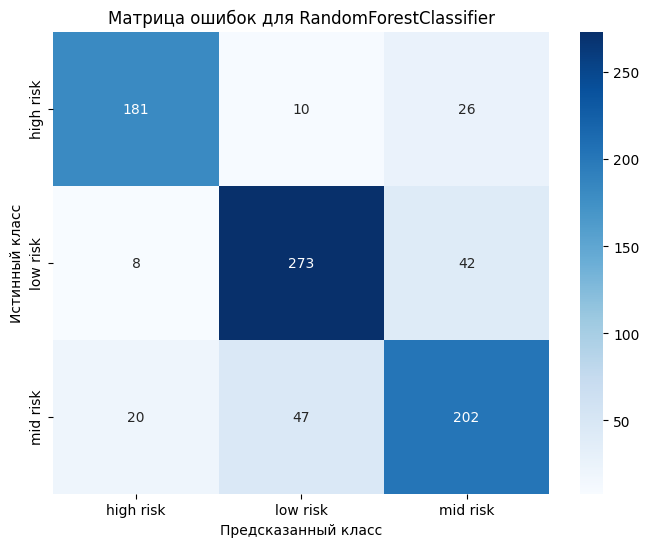

In [38]:
y_train_pred_encoded = cross_val_predict(best_model_rf, 
                                         X_train, 
                                         y_train_encoded, 
                                         cv=cv_strategy, 
                                         n_jobs=-1)
y_train_pred_original = le.inverse_transform(y_train_pred_encoded)
target_names=le.classes_
cm = confusion_matrix(y_train, y_train_pred_original, labels=target_names) 

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Матрица ошибок для RandomForestClassifier')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

Чтобы снизить вероятность ошибочного отнесения объекта к классу low_risk (так называемая ошибка первого рода для этого класса, когда мы предсказываем low_risk, но на самом деле это другой класс), нам необходимо повысить порог вероятности для класса low_risk.

Это означает, что модель должна быть более "уверена" в том, что объект принадлежит к low_risk, прежде чем присвоить ему эту метку. Если этой высокой уверенности нет, объект будет "перенаправлен" в один из других классов (high_risk или medium_risk).

In [39]:
y_pred_proba_rf = best_model_rf.predict_proba(X_train)
print(y_pred_proba_rf[:5])

[[0.98  0.02  0.   ]
 [0.02  0.965 0.015]
 [0.    0.84  0.16 ]
 [0.    0.    1.   ]
 [0.    0.02  0.98 ]]


In [40]:
le.classes_

array(['high risk', 'low risk', 'mid risk'], dtype=object)

Индекс класса 'low_risk' в LabelEncoder: 1

--- Classification Report для RandomForestClassifier на обучающей выборке (с порогом 0.75 для 'low_risk') ---
              precision    recall  f1-score   support

   high risk       0.91      0.97      0.94       217
    low risk       1.00      0.83      0.91       323
    mid risk       0.84      0.96      0.89       269

    accuracy                           0.91       809
   macro avg       0.92      0.92      0.91       809
weighted avg       0.92      0.91      0.91       809



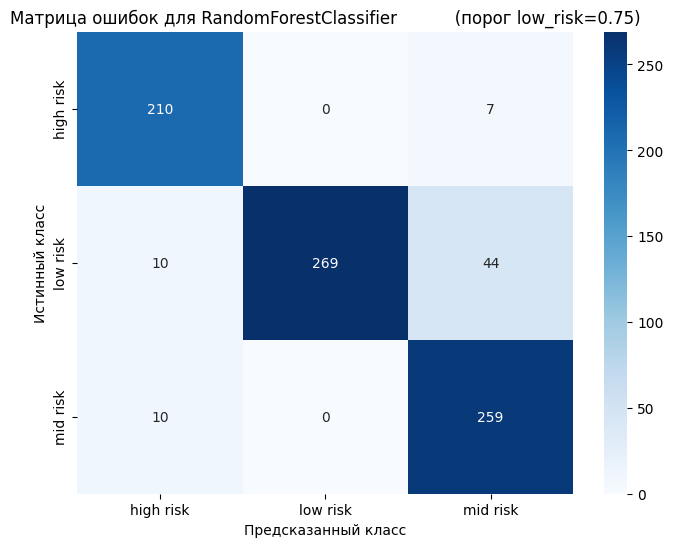

In [41]:
# индекс класса 'low_risk' после LabelEncoder
low_risk_class_index = np.where(le.classes_ == 'low risk')[0][0]
print(f"Индекс класса 'low_risk' в LabelEncoder: {low_risk_class_index}")


# Определяем новый порог для класса 'low_risk'
new_low_risk_threshold = 0.75  # обычно порог - это просто argmax,
            
y_pred_rf_custom_threshold_encoded = np.zeros(len(y_pred_proba_rf), dtype=int)

for i in range(len(y_pred_proba_rf)):
    
    sample_probs = y_pred_proba_rf[i]

    # Если предсказанная вероятность для low_risk ниже нового порога,
    # или если max_proba принадлежит low_risk, но ниже порога
    if (np.argmax(sample_probs) == low_risk_class_index and 
        sample_probs[low_risk_class_index] < new_low_risk_threshold):

        # Исключаем 'low_risk' из рассмотрения для этого образца и 
        # выбираем следующий лучший класс
        temp_probs = np.copy(sample_probs)
        temp_probs[low_risk_class_index] = -1 # чтобы argmax его проигнорировал
        y_pred_rf_custom_threshold_encoded[i] = np.argmax(temp_probs)
    else:
        # Если low_risk не был лучшим, или он был лучшим и 
        # прошел порог, оставляем как есть
        y_pred_rf_custom_threshold_encoded[i] = np.argmax(sample_probs)


y_pred_rf_custom_threshold = le.inverse_transform(
    y_pred_rf_custom_threshold_encoded
    )

# --- Оценка модели с новым порогом ---
print(f"\n--- Classification Report для RandomForestClassifier \
на обучающей выборке (с порогом {new_low_risk_threshold} \
для 'low_risk') ---")
print(classification_report(y_train, 
                            y_pred_rf_custom_threshold, 
                            target_names=target_names))

# Построение матрицы ошибок с новым порогом
cm_custom_threshold = confusion_matrix(y_train, 
                                       y_pred_rf_custom_threshold, 
                                       labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom_threshold, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title(f'Матрица ошибок для RandomForestClassifier \
          (порог low_risk={new_low_risk_threshold})')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

C порогом в 0.75 на обучающей выборке нет ошибочно отнесенных к классу low risk


F1-Score (weighted) с порогом: 0.8254

--- Classification Report для RandomForestClassifier на тестовой выборке (с порогом 0.75 для 'low_risk') ---
              precision    recall  f1-score   support

   high risk       0.93      0.95      0.94        55
    low risk       1.00      0.63      0.77        81
    mid risk       0.68      0.97      0.80        67

    accuracy                           0.83       203
   macro avg       0.87      0.85      0.84       203
weighted avg       0.87      0.83      0.83       203



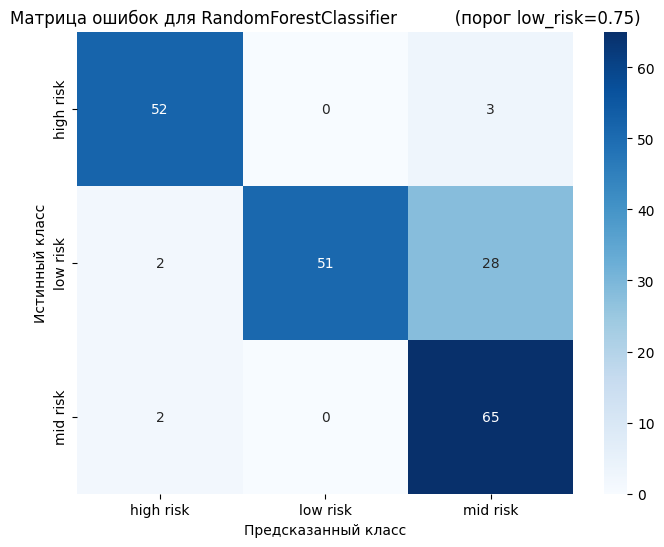

In [42]:
# Оценка RandomForestClassifier на тестовой выборке
y_pred_rf_encoded = grid_search_rf.predict_proba(X_test)

new_low_risk_threshold = 0.75 
            
y_pred_rf_custom_threshold_encoded = np.zeros(len(y_pred_rf_encoded), dtype=int)

for i in range(len(y_pred_rf_encoded)):
    
    sample_probs = y_pred_rf_encoded[i]

    if (np.argmax(sample_probs) == low_risk_class_index and 
        sample_probs[low_risk_class_index] < new_low_risk_threshold):

        temp_probs = np.copy(sample_probs)
        temp_probs[low_risk_class_index] = -1 
        y_pred_rf_custom_threshold_encoded[i] = np.argmax(temp_probs)
    else:
        y_pred_rf_custom_threshold_encoded[i] = np.argmax(sample_probs)


y_pred_rf_custom_threshold_test = le.inverse_transform(
    y_pred_rf_custom_threshold_encoded
    )

# --- Оценка модели с новым порогом ---
f1_score_custom_threshold = f1_score(y_test_encoded, 
                                     y_pred_rf_custom_threshold_encoded, 
                                     average='weighted') 

print(f"\nF1-Score (weighted) с порогом: {f1_score_custom_threshold:.4f}")
print(f"\n--- Classification Report для RandomForestClassifier \
на тестовой выборке (с порогом {new_low_risk_threshold} \
для 'low_risk') ---")
print(classification_report(y_test, 
                            y_pred_rf_custom_threshold_test, 
                            target_names=target_names))

# Построение матрицы ошибок с новым порогом
cm_custom_threshold = confusion_matrix(y_test, 
                                       y_pred_rf_custom_threshold_test, 
                                       labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom_threshold, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title(f'Матрица ошибок для RandomForestClassifier \
          (порог low_risk={new_low_risk_threshold})')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()


<a href='#content'>Вернуться к оглавлению</a> 

## <h2 id="conclusion-recommendations">Общий вывод и оценка важности признаков</h2>


In [43]:
# --- Подготовка данных для SHAP ---
# Используем данные, на которых модель обучалась,
X_train_processed = (best_model_rf
                     .named_steps['preprocessor']
                     .transform(X_train))


ohe_feature_names = (best_model_rf
                     .named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(cat_cols))
feature_names = np.concatenate([ohe_feature_names, interval_cols])

# Если X_train_processed - это разреженная матрица,
# преобразуйте её в плотный массив или DataFrame для SHAP
if hasattr(X_train_processed, 'toarray'):
    X_train_processed_df = pd.DataFrame(
        X_train_processed.toarray(), 
        columns=feature_names)
else:
    X_train_processed_df = pd.DataFrame(
        X_train_processed, 
        columns=feature_names)

print("\nПодготовленные данные для SHAP:")
print(X_train_processed_df.head())
print(f"Количество признаков после \
      препроцессинга: {X_train_processed_df.shape[1]}")


Подготовленные данные для SHAP:
   age_bins_15-19  age_bins_20-24  age_bins_25-29  age_bins_30-34  \
0             1.0             0.0             0.0             0.0   
1             1.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             1.0             0.0   
4             0.0             1.0             0.0             0.0   

   age_bins_35-39  age_bins_40-44  age_bins_45-49  age_bins_50+  age_bins_<15  \
0             0.0             0.0             0.0           0.0           0.0   
1             0.0             0.0             0.0           0.0           0.0   
2             0.0             0.0             0.0           0.0           1.0   
3             0.0             0.0             0.0           0.0           0.0   
4             0.0             0.0             0.0           0.0           0.0   

   systolic_bp    bs  body_temp  heart_rate  pulse_pressure  
0  

In [44]:
explainer = shap.TreeExplainer(best_model_rf.named_steps['classifier'])
shap_values = explainer.shap_values(X_train_processed_df)
print(f"\nSHAP-значения вычислены для {len(shap_values)} классов.")
print(f"Форма SHAP-значений для первого класса: {shap_values[1].shape}")


SHAP-значения вычислены для 809 классов.
Форма SHAP-значений для первого класса: (14, 3)


In [45]:
shap_values[:, :, 1].shape

(809, 14)


Влияние признаков на предсказание класса 'low risk' (SHAP Summary Plot)


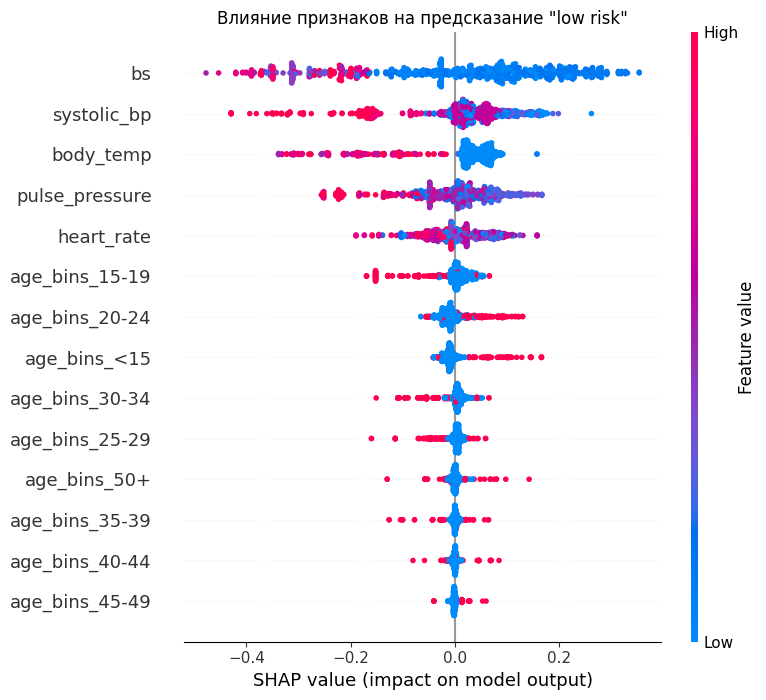

In [46]:

low_risk_class_index = np.where(le.classes_ == 'low risk')[0][0]
print(f"\nВлияние признаков на предсказание класса '{le.classes_[low_risk_class_index]}' (SHAP Summary Plot)")
shap.summary_plot(shap_values[:, :, low_risk_class_index], 
                  X_train_processed_df, 
                  feature_names=feature_names, 
                  show=False)
plt.title(f'Влияние признаков на предсказание "{le.classes_[low_risk_class_index]}"')
plt.tight_layout()
plt.show()


Влияние признаков на предсказание класса 'mid risk' (SHAP Summary Plot)


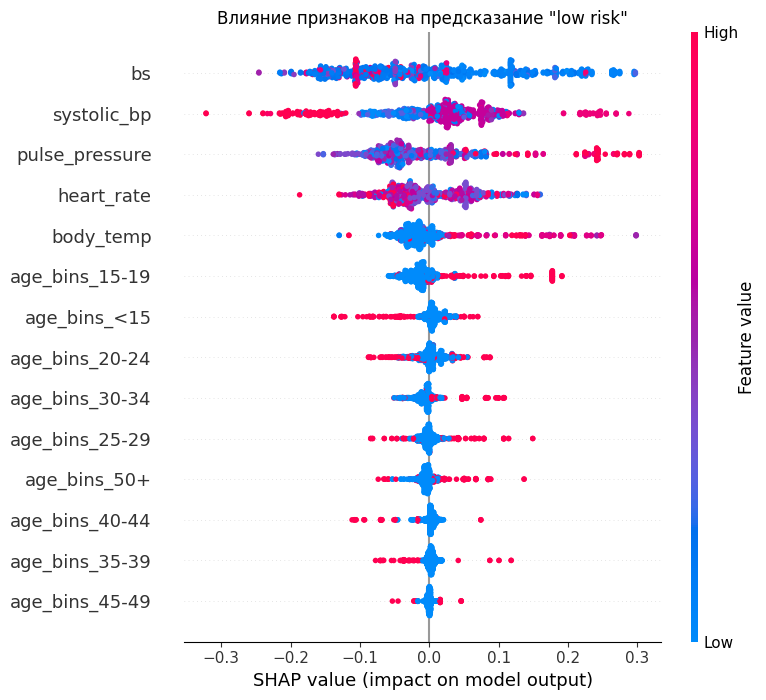

In [47]:
mid_risk_class_index = np.where(le.classes_ == 'mid risk')[0][0]
print(f"\nВлияние признаков на предсказание класса '{le.classes_[mid_risk_class_index]}' (SHAP Summary Plot)")
shap.summary_plot(shap_values[:, :, mid_risk_class_index], 
                  X_train_processed_df, 
                  feature_names=feature_names, 
                  show=False)
plt.title(f'Влияние признаков на предсказание "{le.classes_[low_risk_class_index]}"')
plt.tight_layout()
plt.show()


Влияние признаков на предсказание класса 'high risk' (SHAP Summary Plot)


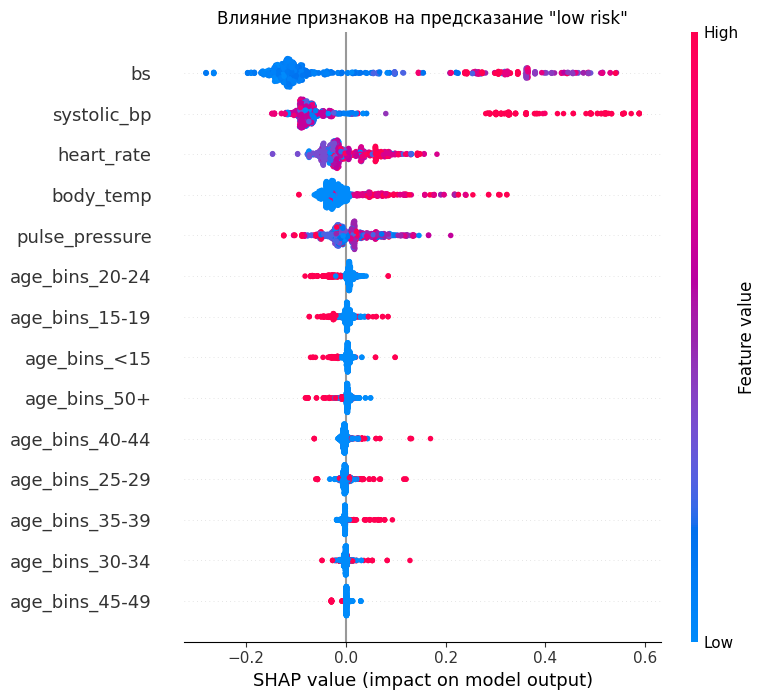

In [48]:
high_risk_class_index = np.where(le.classes_ == 'high risk')[0][0]
print(f"\nВлияние признаков на предсказание класса '{le.classes_[high_risk_class_index]}' (SHAP Summary Plot)")
shap.summary_plot(shap_values[:, :, high_risk_class_index], 
                  X_train_processed_df, 
                  feature_names=feature_names, 
                  show=False)
plt.title(f'Влияние признаков на предсказание "{le.classes_[low_risk_class_index]}"')
plt.tight_layout()
plt.show()

Признаки с положительным SHAP value (справа от нуля на графике) увеличивают вероятность класса.

Низкие или отрицательные значения признаков (слева от нуля) снижают риск.

**Точность (precision) для low risk — 1.00, что говорит о том, что модель не допускает ложных положительных результатов для этого класса. Что важно с учетом контекста задачи, ни одна пациентка со средним или высоким риском не будет отнесена к низкому риску.**


F1-Score (weighted) на       обучающей выборке: 0.9123

Classification Report для RandomForestClassifier на обучающей выборке (с порогом 0.75 для 'low_risk') ---
              precision    recall  f1-score   support

   high risk       0.91      0.97      0.94       217
    low risk       1.00      0.83      0.91       323
    mid risk       0.84      0.96      0.89       269

    accuracy                           0.91       809
   macro avg       0.92      0.92      0.91       809
weighted avg       0.92      0.91      0.91       809



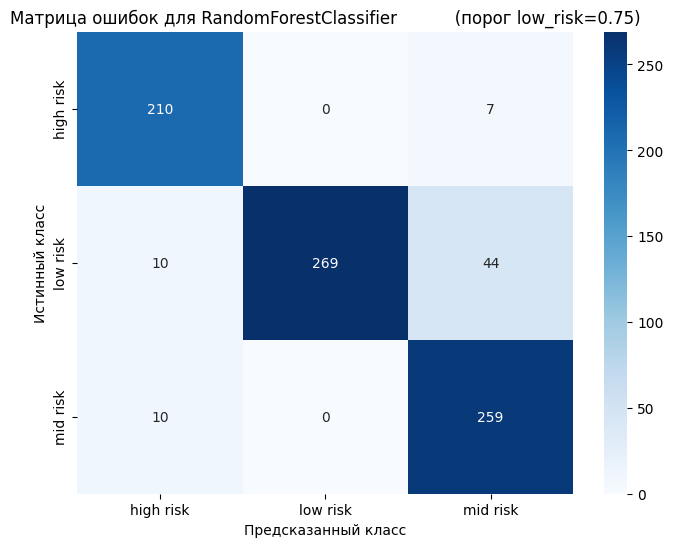

In [49]:
# --- Оценка модели с новым порогом ---
f1_score_custom_threshold = f1_score(y_train, 
                                     y_pred_rf_custom_threshold, 
                                     average='weighted') 
print(f"\nF1-Score (weighted) на \
      обучающей выборке: {f1_score_custom_threshold:.4f}")
print(f"\nClassification Report для RandomForestClassifier \
на обучающей выборке (с порогом {new_low_risk_threshold} \
для 'low_risk') ---")
print(classification_report(y_train, 
                            y_pred_rf_custom_threshold, 
                            target_names=target_names))

# Построение матрицы ошибок с новым порогом
cm_custom_threshold = confusion_matrix(y_train, 
                                       y_pred_rf_custom_threshold, 
                                       labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom_threshold, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title(f'Матрица ошибок для RandomForestClassifier \
          (порог low_risk={new_low_risk_threshold})')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()


F1-Score (weighted) с порогом: 0.8254

--- Classification Report для RandomForestClassifier на тестовой выборке (с порогом 0.75 для 'low_risk') ---
              precision    recall  f1-score   support

   high risk       0.93      0.95      0.94        55
    low risk       1.00      0.63      0.77        81
    mid risk       0.68      0.97      0.80        67

    accuracy                           0.83       203
   macro avg       0.87      0.85      0.84       203
weighted avg       0.87      0.83      0.83       203



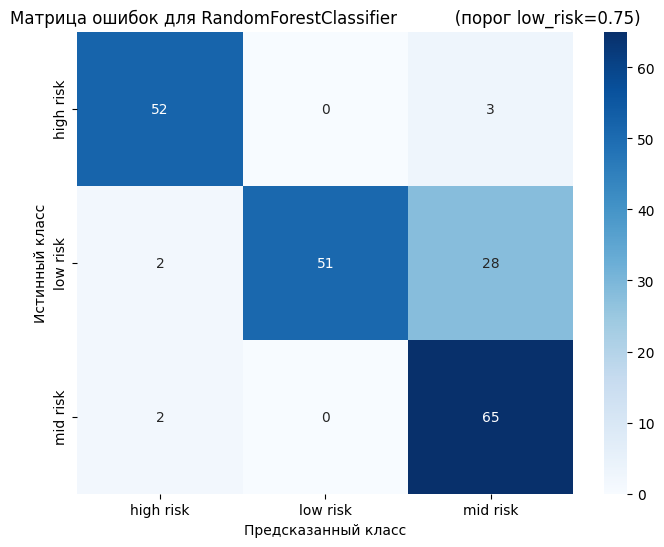

In [50]:
# --- Оценка модели с новым порогом ---
f1_score_custom_threshold = f1_score(y_test_encoded, 
                                     y_pred_rf_custom_threshold_encoded, 
                                     average='weighted') 

print(f"\nF1-Score (weighted) с порогом: {f1_score_custom_threshold:.4f}")
print(f"\n--- Classification Report для RandomForestClassifier \
на тестовой выборке (с порогом {new_low_risk_threshold} \
для 'low_risk') ---")
print(classification_report(y_test, 
                            y_pred_rf_custom_threshold_test, 
                            target_names=target_names))

# Построение матрицы ошибок с новым порогом
cm_custom_threshold = confusion_matrix(y_test, 
                                       y_pred_rf_custom_threshold_test, 
                                       labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom_threshold, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title(f'Матрица ошибок для RandomForestClassifier \
          (порог low_risk={new_low_risk_threshold})')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

<a href='#content'>Вернуться к оглавлению</a> 